In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers import Dropout
from keras.engine.sequential import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD

In [142]:
data_path = 'data/201709-202201 (1).csv'

data = pd.read_csv(data_path)
data = data.drop(['Unnamed: 0', 'timestamp'], axis=1)[5:]

data.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count,MACD,SMA,OBV,RSI,MFI,vader_pos,vader_neg,vader_neu,vader_compound,pos_count,neg_count,neu_count
5,4397.38,4649.23,4356.42,4605.80,16634.104205,25771,285.089024,4497.096,22063.849300,55.804116,94.168204,0.096980,0.038725,0.864275,0.150565,44,11,47
6,4605.81,4674.34,4475.00,4615.00,9254.851427,17813,285.822927,4500.116,31318.700727,54.227988,58.672909,0.106902,0.027716,0.865382,0.192225,47,16,39
7,4615.00,4679.97,4125.99,4312.00,23693.301623,35732,261.651987,4441.264,7625.399105,47.057603,86.010359,0.097187,0.069562,0.833250,0.090550,38,27,31
8,4327.41,4379.78,4164.00,4308.72,9974.388235,17679,261.390335,4447.608,-2348.989130,48.818866,65.572469,0.096021,0.041196,0.862784,0.133598,38,17,42
9,4322.44,4322.44,4010.00,4226.22,14724.204144,20432,254.809138,4413.548,-17073.193274,48.392729,74.347259,0.107818,0.035131,0.857051,0.180167,46,10,43


In [143]:
'''Price Data:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator:'''
# data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator in 30 MIN data:'''
# data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count', 'pos_keywords_occur', 'neg_keywords_occur'], axis=1)

'''Price Data + Selected Features'''
data_features = data.drop(['price_close', 'MFI', 'vader_compound',	'pos_count', 'neg_count', 'neu_count'], axis=1)

data_labels = data['price_close']

scaler_feature = MinMaxScaler(feature_range=(0, 1))
scaler_label = MinMaxScaler(feature_range=(0, 1))

feature = scaler_feature.fit_transform(data_features.to_numpy())
label = scaler_label.fit_transform(data_labels.to_numpy().reshape(-1, 1))

In [144]:
def split_data(f, l, delay):
    feature, label = [], []

    for i in range(len(f) - delay):
        feature.append(f[i: i + delay])
        label.append(l[i + delay-1])
        
    return np.array(feature), np.array(label).squeeze()

window_size = 5

feature, label = split_data(feature, label, window_size)

train_size = int(0.8 * len(label))

X_train, X_test = feature[:train_size], feature[train_size:]
y_train, y_test = label[:train_size], label[train_size:]

print(X_train.shape, X_test.shape)

(990, 5, 12) (248, 5, 12)


In [145]:
# split train X data into 5 datasets
newarr = np.array_split(X_train, 5)
X_train_1 = newarr[0] 
X_train_2 = newarr[1]
X_train_3 = newarr[2]
X_train_4 = newarr[3]
X_train_5 = newarr[4]

# split train y data into 5 datasets
newarr_y = np.array_split(y_train, 5)
y_train_1 = newarr_y[0] 
y_train_2 = newarr_y[1]
y_train_3 = newarr_y[2]
y_train_4 = newarr_y[3]
y_train_5 = newarr_y[4]

In [146]:
# Train dataset 1 （1-4）
X_train_dataset_1 = X_train_1+X_train_2+X_train_3+X_train_4

# Train dataset 2 （1-3，5）
X_train_dataset_2 = X_train_1+X_train_2+X_train_3+X_train_5

# Train dataset 3 （1，2，4，5）
X_train_dataset_3 = X_train_1+X_train_2+X_train_4+X_train_5

# Train dataset 4 （1，3-5）
X_train_dataset_4 = X_train_1+X_train_3+X_train_4+X_train_5

# Train dataset 5 （2-5）
X_train_dataset_5 = X_train_2+X_train_3+X_train_4+X_train_5

In [147]:
# Test dataset 1 （1-4）
y_train_dataset_1 = y_train_1+y_train_2+y_train_3+y_train_4

# Test dataset 2 （1-3，5）
y_train_dataset_2 = y_train_1+y_train_2+y_train_3+y_train_5

# Test dataset 3 （1，2，4，5）
y_train_dataset_3 = y_train_1+y_train_2+y_train_4+y_train_5

# Test dataset 4 （1，3-5）
y_train_dataset_4 = y_train_1+y_train_3+y_train_4+y_train_5

# Test dataset 5 （2-5）
y_train_dataset_5 = y_train_2+y_train_3+y_train_4+y_train_5

In [148]:
X_train_datasets = [X_train_dataset_1,X_train_dataset_2,X_train_dataset_3,X_train_dataset_4,X_train_dataset_5]
y_train_datasets = [y_train_dataset_1,y_train_dataset_2,y_train_dataset_3,y_train_dataset_4,y_train_dataset_5]

# Base Models

In [149]:
nGRU = 5
nLSTM = 5

In [150]:
GRUs = [
    keras.Sequential([
        layers.GRU(2048),
        layers.Dense(1024),
        layers.Dense(1)
    ]) for i in range(nGRU)
]


LSTMs = [
    keras.Sequential([
        layers.SimpleRNN(512),
        layers.Dense(512),
        layers.Dense(1)
    ]) for i in range(nLSTM)
]

In [151]:
for model, X, y in zip(GRUs, X_train_datasets, y_train_datasets):
    model.compile(loss='mean_squared_error',
                optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00005),
                metrics=[keras.metrics.RootMeanSquaredError()]
                )
    history = model.fit(X, y,
                        epochs=30,
                        batch_size=4,
                        shuffle=True
                        )


/home/charles/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
50/50 [==============================] - 6s 8ms/step - loss: 2.0379 - root_mean_squared_error: 1.4276
Epoch 2/30
50/50 [==============================] - 0s 9ms/step - loss: 0.0120 - root_mean_squared_error: 0.1096
Epoch 3/30
50/50 [==============================] - 0s 9ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421
Epoch 4/30
50/50 [==============================] - 0s 9ms/step - loss: 0.0011 - root_mean_squared_error: 0.0338
Epoch 5/30
50/50 [==============================] - 0s 10ms/step - loss: 6.2609e-04 - root_mean_squared_error: 0.0250
Epoch 6/30
50/50 [==============================] - 0s 10ms/step - loss: 5.6009e-04 - root_mean_squared_error: 0.0237
Epoch 7/30
50/50 [==============================] - 1s 11ms/step - loss: 4.6305e-04 - root_mean_squared_error: 0.0215
Epoch 8/30
50/50 [==============================] - 1s 11ms/step - loss: 3.1400e-04 - root_mean_squared_error: 0.0177
Epoch 9/30
50/50 [==============================] - 0s 10ms/step - loss: 2.8

In [152]:
for model, X, y in zip(LSTMs, X_train_datasets, y_train_datasets):
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    history = model.fit(X, y, 
                        batch_size=16, 
                        epochs=50, 
                        shuffle=False,
                        )

Epoch 1/50
13/13 [==============================] - 1s 3ms/step - loss: 11.8241 - root_mean_squared_error: 3.4386
Epoch 2/50
13/13 [==============================] - 0s 3ms/step - loss: 0.5543 - root_mean_squared_error: 0.7445
Epoch 3/50
13/13 [==============================] - 0s 3ms/step - loss: 0.1260 - root_mean_squared_error: 0.3549
Epoch 4/50
13/13 [==============================] - 0s 3ms/step - loss: 0.0561 - root_mean_squared_error: 0.2369
Epoch 5/50
13/13 [==============================] - 0s 3ms/step - loss: 0.0205 - root_mean_squared_error: 0.1433
Epoch 6/50
13/13 [==============================] - 0s 3ms/step - loss: 0.0084 - root_mean_squared_error: 0.0917
Epoch 7/50
13/13 [==============================] - 0s 3ms/step - loss: 0.0066 - root_mean_squared_error: 0.0811
Epoch 8/50
13/13 [==============================] - 0s 3ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730
Epoch 9/50
13/13 [==============================] - 0s 3ms/step - loss: 0.0047 - root_mean_squa

In [153]:
pred_GRU = []
pred_LSTM = []
for gru, lstm, data in zip(GRUs, LSTMs, newarr[::-1]):
    pred_GRU = gru.predict(data).tolist() + pred_GRU
    pred_LSTM = lstm.predict(data).tolist() + pred_LSTM
    
pred_GRU = np.array(pred_GRU)
pred_LSTM = np.array(pred_LSTM)

X_tmp = np.concatenate((pred_GRU, pred_LSTM), axis=1)

In [154]:
pred_prices = scaler_label.inverse_transform(np.mean(np.array(pred_GRU), axis=1).reshape(-1, 1))
true_prices = scaler_label.inverse_transform(y_train.reshape(-1,1))

mse = mean_squared_error(true_prices, pred_prices)
rmse = mean_squared_error(true_prices, pred_prices, squared=False)
mae = mean_absolute_error(true_prices, pred_prices)

print(mse, rmse, mae)

pred_prices = scaler_label.inverse_transform(np.mean(np.array(pred_LSTM), axis=1).reshape(-1, 1))

mse = mean_squared_error(true_prices, pred_prices)
rmse = mean_squared_error(true_prices, pred_prices, squared=False)
mae = mean_absolute_error(true_prices, pred_prices)

print(mse, rmse, mae)

2126749.680505298 1458.3379856896336 1202.1609634730064
2131249.3483433463 1459.8799088772153 1202.8997539049726


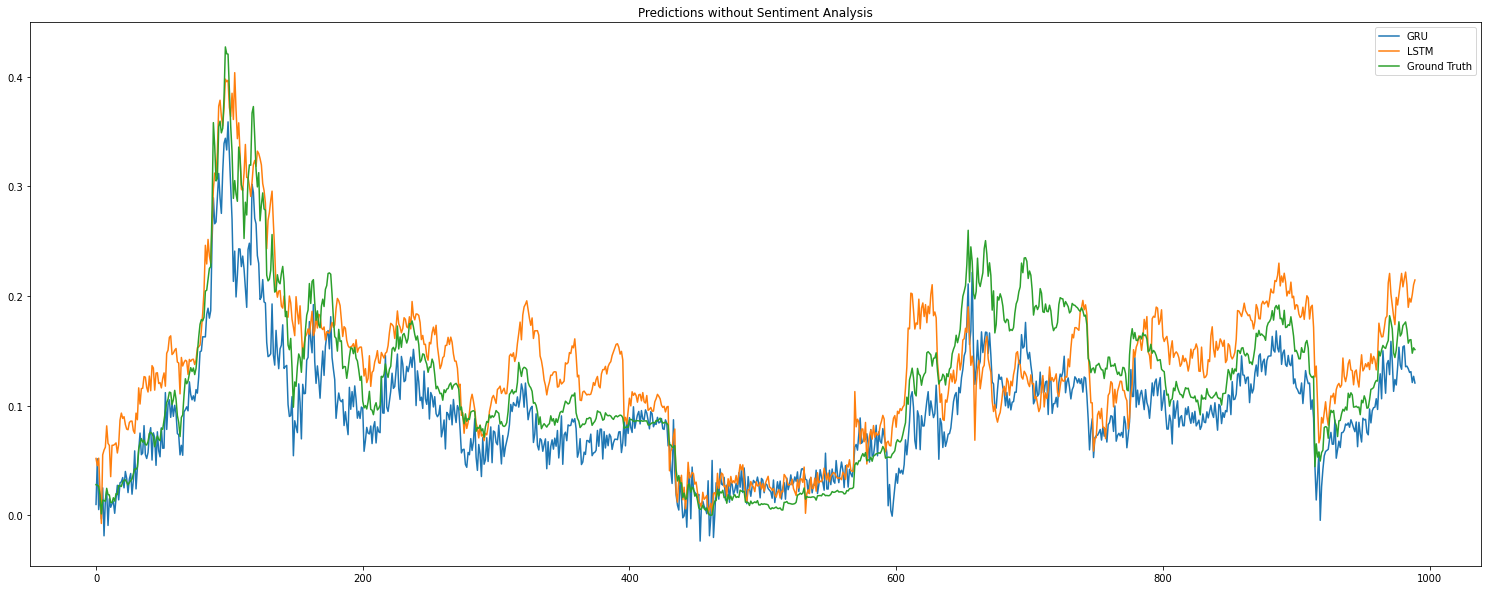

In [155]:
plt.figure(figsize=(26, 10))

plt.plot(pred_GRU, label='GRU')
plt.plot(pred_LSTM, label='LSTM')
plt.plot(y_train, label='Ground Truth')
plt.legend()
plt.title('Predictions without Sentiment Analysis')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.show()

# MLP

In [159]:
batch_size = 8
model = Sequential([Dense(1)])

model.compile(optimizer= Adam(learning_rate=5e-4), loss='mse', metrics=['accuracy'])

model.fit(X_tmp, y_train, batch_size = batch_size, epochs=50, verbose = 1)

Epoch 1/50
124/124 [==============================] - 0s 907us/step - loss: 0.0081 - accuracy: 0.0010
Epoch 2/50
124/124 [==============================] - 0s 845us/step - loss: 0.0030 - accuracy: 0.0010
Epoch 3/50
124/124 [==============================] - 0s 806us/step - loss: 0.0022 - accuracy: 0.0010
Epoch 4/50
124/124 [==============================] - 0s 808us/step - loss: 0.0020 - accuracy: 0.0010
Epoch 5/50
124/124 [==============================] - 0s 813us/step - loss: 0.0019 - accuracy: 0.0010
Epoch 6/50
124/124 [==============================] - 0s 841us/step - loss: 0.0017 - accuracy: 0.0010
Epoch 7/50
124/124 [==============================] - 0s 865us/step - loss: 0.0016 - accuracy: 0.0010
Epoch 8/50
124/124 [==============================] - 0s 781us/step - loss: 0.0015 - accuracy: 0.0010
Epoch 9/50
124/124 [==============================] - 0s 756us/step - loss: 0.0013 - accuracy: 0.0010
Epoch 10/50
124/124 [==============================] - 0s 765us/step - loss: 0.001

In [160]:
pred_GRU = [model.predict(X_test) for model in GRUs]
pred_LSTM = [model.predict(X_test) for model in LSTMs]

pred_GRU = np.mean(np.array(pred_GRU), axis=0)
pred_LSTM = np.mean(np.array(pred_LSTM), axis=0)

X_tmp2 = np.concatenate((pred_GRU, pred_LSTM), axis=1).squeeze()

prediction = model.predict(X_tmp2)

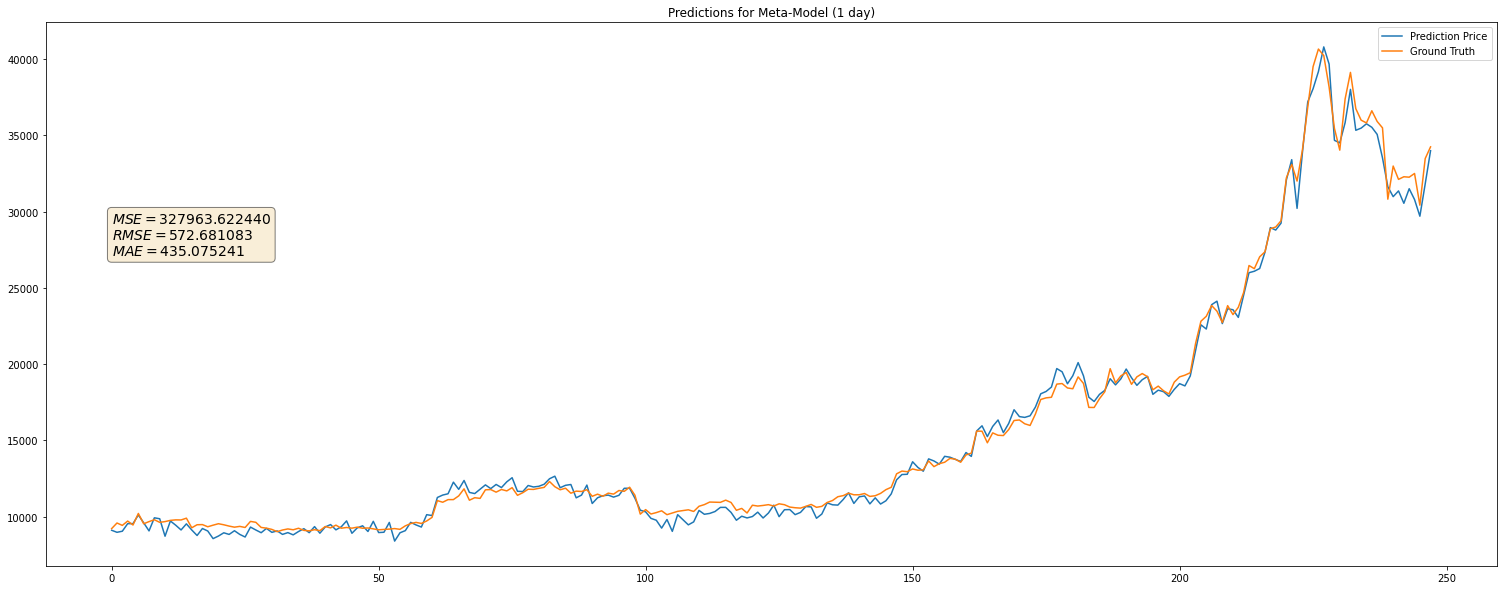

In [161]:
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(true_prices, pred_prices)
rmse = mean_squared_error(true_prices, pred_prices, squared=False)
mae = mean_absolute_error(true_prices, pred_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('Predictions for Meta-Model (1 day)')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 30000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()